C:\Users\PLN\AppData\Local\Temp\ipykernel_1468\2337416488.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = df['Vehicles'].asfreq('H').fillna(method='ffill')
C:\Users\PLN\AppData\Local\Temp\ipykernel_1468\2337416488.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = df['Vehicles'].asfreq('H').fillna(method='ffill')


Total observations: 14592
Training observations: 11673 (from 2015-11-01 00:00:00 to 2017-03-01 08:00:00)
Testing observations: 2919 (from 2017-03-01 09:00:00 to 2017-06-30 23:00:00)
Forecast horizon (length of test set): 2919


C:\Users\PLN\AppData\Local\Temp\ipykernel_1468\2337416488.py:114: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PLN\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


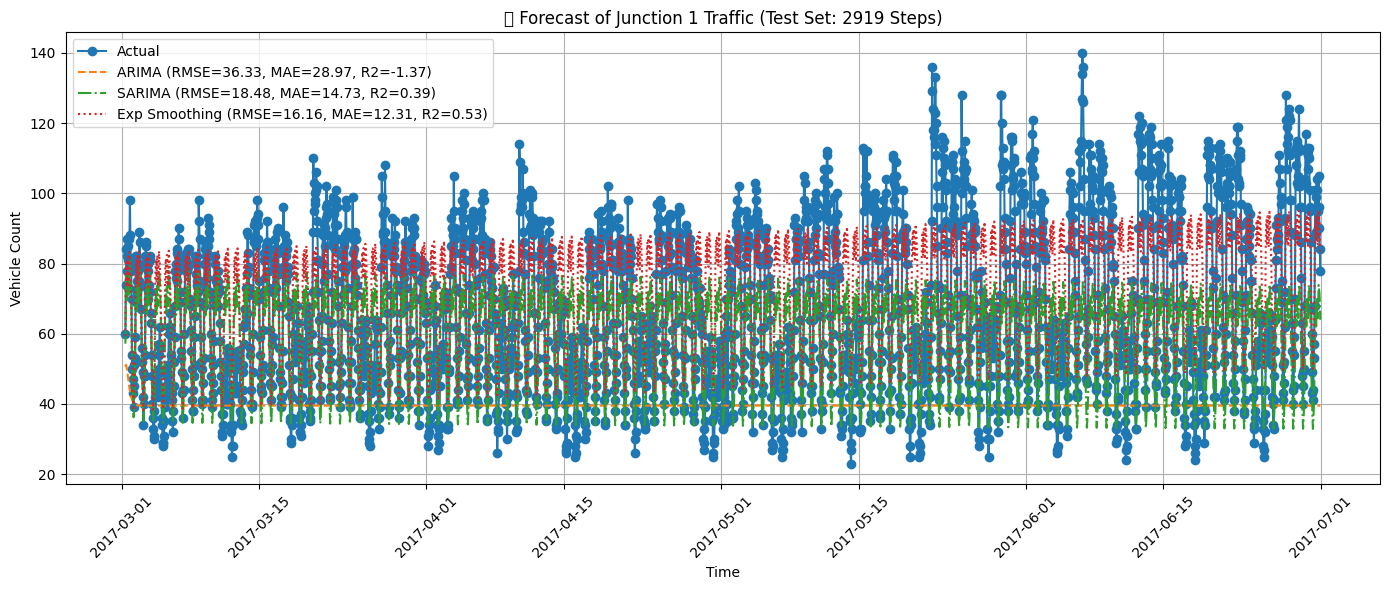

In [1]:
# 📚 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Added r2_score

# 📄 Load data
df = pd.read_csv("traffic.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df[df['Junction'] == 1].copy()
df.set_index('DateTime', inplace=True)
ts = df['Vehicles'].asfreq('H').fillna(method='ffill')

# 🔮 Define Train/Test Split (80/20)
n_total = len(ts)
split_idx = int(n_total * 0.8)

if split_idx <= 0 or split_idx >= n_total: # Ensure both train and test sets are non-empty
    raise ValueError(
        f"Time series is too short for a meaningful 80/20 split. "
        f"Total length: {n_total}, calculated 80% split index: {split_idx}. "
        "This would result in an empty train or test set. "
        "Please ensure your time series `ts` has sufficient data."
    )

train_ts = ts.iloc[:split_idx]
test_ts = ts.iloc[split_idx:]

# Update forecast_horizon based on the new test set size
forecast_horizon = len(test_ts)

# context_length = 168  # Original context length, can be kept for reference or if needed for other comparisons
                        # This variable is not used for the 80/20 split definition below.

print(f"Total observations: {n_total}")
print(f"Training observations: {len(train_ts)} (from {train_ts.index.min()} to {train_ts.index.max()})")
print(f"Testing observations: {len(test_ts)} (from {test_ts.index.min()} to {test_ts.index.max()})")
print(f"Forecast horizon (length of test set): {forecast_horizon}")


# 📈 ARIMA Model
# Features used: Past values of the time series (Vehicles count).
# The model learns patterns from the historical sequence of vehicle counts.
# Order (p,d,q) = (2,0,2) indicates:
# p=2: Autoregressive component using 2 lagged values of the series.
# d=0: No differencing applied (series assumed stationary or stationarity handled by AR/MA).
# q=2: Moving average component using 2 lagged forecast errors.
arima_model = ARIMA(train_ts, order=(2, 0, 2))
arima_fit = arima_model.fit()
arima_forecast = pd.Series(arima_fit.forecast(steps=forecast_horizon).values, index=test_ts.index)

# 📉 Exponential Smoothing
# Features used: Past values of the time series (Vehicles count).
# The model captures trend and seasonality from the historical sequence.
# trend='add': Assumes an additive trend component.
# seasonal='add': Assumes an additive seasonal component.
# seasonal_periods=24: Specifies a daily seasonality (24 hourly periods).
exp_model = ExponentialSmoothing(train_ts, trend='add', seasonal='add', seasonal_periods=24)
exp_fit = exp_model.fit()
exp_forecast = pd.Series(exp_fit.forecast(steps=forecast_horizon).values, index=test_ts.index)

# 🔁 SARIMA Model
# Features used: Past values of the time series (Vehicles count).
# The model learns non-seasonal and seasonal patterns from the historical sequence.
# order (p,d,q) = (2,0,2): Non-seasonal components (AR, I, MA).
# seasonal_order (P,D,Q,s) = (1,0,1,24): Seasonal components.
#   P=1: Seasonal autoregressive component using 1 seasonal lag.
#   D=0: No seasonal differencing.
#   Q=1: Seasonal moving average component using 1 seasonal lagged forecast error.
#   s=24: Seasonality period (daily).
sarima_model = SARIMAX(train_ts, order=(2, 0, 2), seasonal_order=(1, 0, 1, 24))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = pd.Series(sarima_fit.forecast(steps=forecast_horizon).values, index=test_ts.index)

# 📏 Evaluation function
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return round(rmse, 2), round(mae, 2), round(r2, 2)

# 📏 Evaluate all models
arima_rmse, arima_mae, arima_r2 = evaluate(test_ts, arima_forecast)
exp_rmse, exp_mae, exp_r2 = evaluate(test_ts, exp_forecast)
sarima_rmse, sarima_mae, sarima_r2 = evaluate(test_ts, sarima_forecast)


# 📋 Comparison Table
comparison_df = pd.DataFrame({
    'Actual': test_ts.values,
    'ARIMA Forecast': arima_forecast.values,
    'SARIMA Forecast': sarima_forecast.values,
    'Exponential Smoothing Forecast': exp_forecast.values,
}, index=test_ts.index)

# print("\n📊 Forecast vs Actual (Test Set):") # Updated comment
# print(comparison_df)

# 📊 Aligned Timeline Plot
plt.figure(figsize=(14, 6))
plt.plot(test_ts.index, test_ts.values, label="Actual", marker='o')
plt.plot(test_ts.index, arima_forecast.values, label=f"ARIMA (RMSE={arima_rmse}, MAE={arima_mae}, R2={arima_r2})", linestyle='--')
plt.plot(test_ts.index, sarima_forecast.values, label=f"SARIMA (RMSE={sarima_rmse}, MAE={sarima_mae}, R2={sarima_r2})", linestyle='-.')
plt.plot(test_ts.index, exp_forecast.values, label=f"Exp Smoothing (RMSE={exp_rmse}, MAE={exp_mae}, R2={exp_r2})", linestyle=':')
plt.title(f"📈 Forecast of Junction 1 Traffic (Test Set: {forecast_horizon} Steps)") # Updated title
plt.xlabel("Time")
plt.ylabel("Vehicle Count")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\PLN\AppData\Local\Temp\ipykernel_21372\4272037944.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = df['Vehicles'].asfreq('H').fillna(method='ffill')
C:\Users\PLN\AppData\Local\Temp\ipykernel_21372\4272037944.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = df['Vehicles'].asfreq('H').fillna(method='ffill')
c:\Users\PLN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\PLN\AppData\Local\Temp\ipykernel_21372\4272037944.py:94: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PLN\AppData\Roaming\Python\Python311\site-packages\IPython\core\pyla

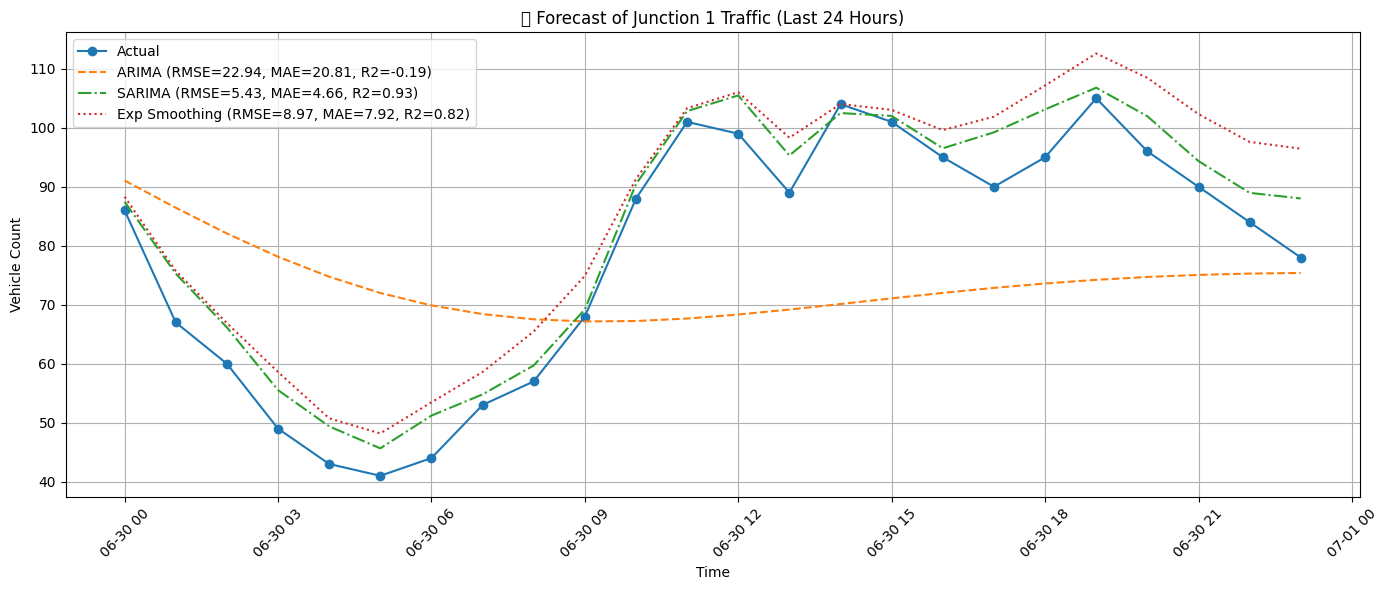

In [2]:
# 📚 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Added r2_score

# 📄 Load data
df = pd.read_csv("traffic.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df[df['Junction'] == 1].copy()
df.set_index('DateTime', inplace=True)
ts = df['Vehicles'].asfreq('H').fillna(method='ffill')

# 🔮 Forecast last 24 hours
forecast_horizon = 24
context_length = 168  # Match Transformer context
train_ts = ts.iloc[-(forecast_horizon + context_length):-forecast_horizon]

test_ts = ts.iloc[-forecast_horizon:]

# 📈 ARIMA Model
# Features used: Past values of the time series (Vehicles count).
# The model learns patterns from the historical sequence of vehicle counts.
# Order (p,d,q) = (2,0,2) indicates:
# p=2: Autoregressive component using 2 lagged values of the series.
# d=0: No differencing applied (series assumed stationary or stationarity handled by AR/MA).
# q=2: Moving average component using 2 lagged forecast errors.
arima_model = ARIMA(train_ts, order=(2, 0, 2))
arima_fit = arima_model.fit()
arima_forecast = pd.Series(arima_fit.forecast(steps=forecast_horizon).values, index=test_ts.index)

# 📉 Exponential Smoothing
# Features used: Past values of the time series (Vehicles count).
# The model captures trend and seasonality from the historical sequence.
# trend='add': Assumes an additive trend component.
# seasonal='add': Assumes an additive seasonal component.
# seasonal_periods=24: Specifies a daily seasonality (24 hourly periods).
exp_model = ExponentialSmoothing(train_ts, trend='add', seasonal='add', seasonal_periods=24)
exp_fit = exp_model.fit()
exp_forecast = pd.Series(exp_fit.forecast(steps=forecast_horizon).values, index=test_ts.index)

# 🔁 SARIMA Model
# Features used: Past values of the time series (Vehicles count).
# The model learns non-seasonal and seasonal patterns from the historical sequence.
# order (p,d,q) = (2,0,2): Non-seasonal components (AR, I, MA).
# seasonal_order (P,D,Q,s) = (1,0,1,24): Seasonal components.
#   P=1: Seasonal autoregressive component using 1 seasonal lag.
#   D=0: No seasonal differencing.
#   Q=1: Seasonal moving average component using 1 seasonal lagged forecast error.
#   s=24: Seasonality period (daily).
sarima_model = SARIMAX(train_ts, order=(2, 0, 2), seasonal_order=(1, 0, 1, 24))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = pd.Series(sarima_fit.forecast(steps=forecast_horizon).values, index=test_ts.index)

# 📏 Evaluation function
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return round(rmse, 2), round(mae, 2), round(r2, 2)

# 📏 Evaluate all models
arima_rmse, arima_mae, arima_r2 = evaluate(test_ts, arima_forecast)
exp_rmse, exp_mae, exp_r2 = evaluate(test_ts, exp_forecast)
sarima_rmse, sarima_mae, sarima_r2 = evaluate(test_ts, sarima_forecast)


# 📋 Comparison Table
comparison_df = pd.DataFrame({
    'Actual': test_ts.values,
    'ARIMA Forecast': arima_forecast.values,
    'SARIMA Forecast': sarima_forecast.values,
    'Exponential Smoothing Forecast': exp_forecast.values,
}, index=test_ts.index)

# print("\n📊 Forecast vs Actual (Last 24 Hours):")
# print(comparison_df)

# 📊 Aligned Timeline Plot
plt.figure(figsize=(14, 6))
plt.plot(test_ts.index, test_ts.values, label="Actual", marker='o')
plt.plot(test_ts.index, arima_forecast.values, label=f"ARIMA (RMSE={arima_rmse}, MAE={arima_mae}, R2={arima_r2})", linestyle='--')
plt.plot(test_ts.index, sarima_forecast.values, label=f"SARIMA (RMSE={sarima_rmse}, MAE={sarima_mae}, R2={sarima_r2})", linestyle='-.')
plt.plot(test_ts.index, exp_forecast.values, label=f"Exp Smoothing (RMSE={exp_rmse}, MAE={exp_mae}, R2={exp_r2})", linestyle=':')
plt.title("📈 Forecast of Junction 1 Traffic (Last 24 Hours)")
plt.xlabel("Time")
plt.ylabel("Vehicle Count")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
